## Virtual Distillation with Classical Shadows

For a detailed overview, see  
[Seif *et al.*, *PRX Quantum* **4**, 010303 (2023)](https://doi.org/10.1103/PRXQuantum.4.010303).

Consider an experimental state described by the density matrix

$$
\rho \;=\; (1-\epsilon)\,\lvert\psi\rangle \langle\psi\rvert 
\;+\;\sum_{\nu}\epsilon_{\nu}\,\lvert\psi_{\nu}\rangle \langle\psi_{\nu}\rvert,
$$

where $ \lvert\psi\rangle $ is the intended pure state, and the remaining terms capture noise.

**Virtual distillation** leverages the fact that

$$
\frac{\rho^n}{\mathrm{tr}(\rho^n)}
\;\;\xrightarrow[n \to \infty]{}\;\;
\lvert\psi\rangle \langle\psi\rvert,
$$

meaning it “distills” out the noise as you consider higher powers of $ \rho $. Consequently, estimating an observable \( O \) via

$$
\frac{\mathrm{tr}\!\bigl(O\,\rho^n\bigr)}{\mathrm{tr}\!\bigl(\rho^n\bigr)}
$$

yields improved accuracy over the usual $ \mathrm{tr}(O\,\rho) $.

Crucially, **classical shadows** enable practical estimation of these multi-copy observables via randomized measurements

In [1]:
using RandomMeas

For this tutorial, we first compute the ground state of the transverse Ising model via DMRG. 

In [2]:
# Number of spins (qubits) in the chain
N = 4

# Define the site indices for an N-qubit system
ξ = siteinds("Qubit", N)

# Strength of the transverse field
B = 1.0

# Build the Hamiltonian using the AutoMPO interface
ampo = AutoMPO()

# Add nearest-neighbor Ising (XX) interactions with coupling = -1
for j in 1:(N - 1)
    ampo .+= -1, "X", j, "X", j + 1
end

# Add a transverse field term in the Z direction on each site
for j in 1:N
    ampo .+= -B, "Z", j
end

# Convert the AutoMPO to a Matrix Product Operator
H = MPO(ampo, ξ)

# --- DMRG Setup ---
# Number of DMRG sweep iterations
dmrg_iter = 5
# Truncation cutoff during MPS compression
dmrg_cutoff = 1e-10
# Generate a random initial MPS state
ψ0 = random_mps(ξ)

# Prepare a Sweeps object to configure DMRG parameters
sweeps = Sweeps(dmrg_iter)
# Control the maximum bond dimensions allowed during sweeps
maxdim!(sweeps, 10, 20, 30, 40, 50, 100)
# Set the truncation cutoff
cutoff!(sweeps, dmrg_cutoff)

# --- Run DMRG to obtain the ground state ---
println("Running DMRG to find the ground state of the transverse field Ising model:")
E, ψ = dmrg(H, ψ0, sweeps)

# Display the computed ground state energy
println("\nGround state energy: ", E)
println("\n---------------------------------------\n")

Running DMRG to find the ground state of the transverse field Ising model:
After sweep 1 energy=-4.750218039867587  maxlinkdim=4 maxerr=0.00E+00 time=8.389
After sweep 2 energy=-4.758767368580261  maxlinkdim=4 maxerr=1.15E-16 time=0.002
After sweep 3 energy=-4.758770481193323  maxlinkdim=4 maxerr=1.59E-17 time=0.001
After sweep 4 energy=-4.758770483142314  maxlinkdim=4 maxerr=1.20E-16 time=0.002
After sweep 5 energy=-4.7587704831436355  maxlinkdim=4 maxerr=2.41E-16 time=0.001

Ground state energy: -4.7587704831436355

---------------------------------------



## Modeling an Experimental Quantum State with Global Depolarization

In this cell, we introduce a depolarizing channel on top of our (pure) DMRG ground state $\lvert \psi \rangle$. The mixed state is constructed as:

$$
\rho \;=\; (1 - p)\,\lvert \psi \rangle \langle \psi \rvert 
\;+\; p\,\frac{I}{2^N},
$$

where $I$ is the $2^N \times 2^N$ identity operator, and $p$ (often called the *noise parameter*) controls the strength of the white noise. A higher $p$ corresponds to a higher level of depolarization.

In [3]:
# Consider an experimental state admixed with white noise of strength p
p = 0.1

# Build the identity operator as an MPO of the same dimension
Ide = MPO(ξ)
for i in 1:N
    Ide[i] = δ(ξ[i]', ξ[i])
end

# Combine the pure-state density matrix and the identity to model global depolarization
ρ = (1-p)*outer(ψ', ψ) + p*Ide/(2^N);

Now, we perform randomized measurements.

In [4]:
NU = 1000  # Number of local random unitaries (per qubit)
NM = 500  # Number of measurement shots per random unitary

measurement_group = MeasurementGroup(ρ,NU,NM;mode="dense");


We then used three batch classical shadows [Rath et al, PRX quantum 2023](https://doi.org/10.1103/PRXQuantum.4.010318) for postprocessing the data.

In [5]:
n = 6  # Number of batch shadows
ρb = get_dense_shadows(measurement_group, number_of_ru_batches=n);

In [6]:
# Compute the nonlinear expectation values and trace moments for purification orders 1 through n.
# The function get_trace_moments computes:
#   - If an MPO observable O is provided (here H), it computes Tr[H * (ρ^n)]
#   - If no observable is provided, it computes Tr[ρ^n]
nonlinear_expectation_values = get_trace_moments(ρb, collect(1:n); O=H)
trace_moments = get_trace_moments(ρb, collect(1:n))

# Convert any complex values to real (if necessary), as energy is a real quantity.
nonlinear_expectation_values = real.(nonlinear_expectation_values)
trace_moments = real.(trace_moments)

# Initialize an array to store energy estimates for each purification order.
Es = zeros(n)

# Loop over the different purification orders
for nt in 1:n
    # Compute the energy estimate as the ratio: Tr[H * ρ^n] / Tr[ρ^n]
    Es[nt] = nonlinear_expectation_values[nt] / trace_moments[nt]
end

# Print the energy estimations for each purification order
println("Estimations for different purification orders n: ", Es)
println("Real energy value: ", E)

Estimations for different purification orders n: [-4.313052299863195, -4.755865877117446, -4.7579520102113415, -4.7571965938194625, -4.757112483409004, -4.757093302684673]
Real energy value: -4.7587704831436355


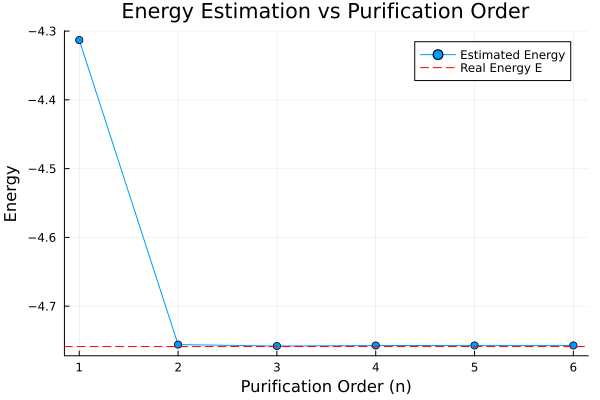

In [7]:
using Plots

# Define the purification orders as a vector.
nt = 1:n  # Assuming n is the number of batch shadows

# Plot the estimated energies as a function of the purification order.
plot(nt, Es, marker=:circle, linestyle=:solid, label="Estimated Energy",
     xlabel="Purification Order (n)", ylabel="Energy", title="Energy Estimation vs Purification Order")

# Add a horizontal dashed line at the value E.
hline!([E], linestyle=:dash, color=:red, label="Real Energy E")